In [ ]:
# --- CELDA 1 ---
import os, glob, itertools, json, math, random, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks

# Reproducibilidad
SEED = 42
tf.random.set_seed(SEED); np.random.seed(SEED); random.seed(SEED)

print("TF:", tf.__version__, "| Keras:", keras.__version__)
print("Devices:", tf.config.list_physical_devices())

# Rutas y constantes
DATA_ROOT = pathlib.Path("Skin_Data")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VAL_FRACTION = 0.2
AUTOTUNE = tf.data.AUTOTUNE


TF: 2.16.2 | Keras: 3.12.0
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
DATA_ROOT = pathlib.Path("../Skin_Data")
print("DATA_ROOT ->", DATA_ROOT.resolve())

# Extensiones válidas de imagen
EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")

# --- Función para recolectar paths y etiquetas ---
def _collect_paths(base: pathlib.Path, split: str):
    # split: "Training" o "Testing"
    def list_dir(d):
        if not d.exists():
            return []
        return [str(p) for p in d.iterdir() if p.is_file() and p.suffix.lower() in EXTS]

    cancer_dir = base / "Cancer" / split
    nonca_dir  = base / "Non_Cancer" / split

    cancer = sorted(list_dir(cancer_dir))
    nonca  = sorted(list_dir(nonca_dir))

    X = cancer + nonca
    y = [1]*len(cancer) + [0]*len(nonca)

    print(f"{split}: Cancer={len(cancer)} | Non_Cancer={len(nonca)} | Total={len(X)}")
    return X, y

# --- Cargar archivos de entrenamiento y prueba ---
X_train_all, y_train_all = _collect_paths(DATA_ROOT, "Training")
X_test,      y_test      = _collect_paths(DATA_ROOT, "Testing")

# Verifica que haya datos
if len(X_train_all) == 0 or len(X_test) == 0:
    raise RuntimeError("No se encontraron imágenes. Revisa la estructura de Skin_Data.")

# --- Split estratificado para validación ---
VAL_FRACTION = 0.2  # ya definida en la celda 1
X_train, X_val, y_train, y_val = train_test_split(
    X_train_all,
    y_train_all,
    test_size=VAL_FRACTION,
    stratify=y_train_all,
    random_state=42
)

# --- Función resumen de los splits ---
def _summary_split(name, X, y):
    y = np.array(y)
    print(f"{name}: {len(X)} imgs | pos={y.sum()} | neg={(y==0).sum()}")

# --- Mostrar resumen ---
_summary_split("train", X_train, y_train)
_summary_split("val",   X_val,   y_val)
_summary_split("test",  X_test,  y_test)

DATA_ROOT -> /Users/santiagovillazon/Documents/7imo Semestre ITC/Ultimas 12 Semanas/M-dulo-2-Implementaci-n-de-un-modelo-de-deep-learning---Santiago-Villaz-n/Skin_Data
Training: Cancer=42 | Non_Cancer=42 | Total=84
Testing: Cancer=42 | Non_Cancer=162 | Total=204
train: 67 imgs | pos=34 | neg=33
val: 17 imgs | pos=8 | neg=9
test: 204 imgs | pos=42 | neg=162


In [ ]:
# --- CELDA 3 (afinada) ---
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE

def decode_img(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    return img, tf.cast(label, tf.float32)

# Augmentations más fuertes
AUG = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.10),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.10),
    layers.RandomTranslation(0.1, 0.1),
], name="augment")

def make_dataset(paths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(buffer_size=max(64, len(paths)), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(decode_img, num_parallel_calls=AUTOTUNE)
    ds = ds.cache() 
    if training:
        ds = ds.map(lambda x, y: (AUG(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train, training=True)
val_ds   = make_dataset(X_val,   y_val,   training=False)
test_ds  = make_dataset(X_test,  y_test,  training=False)

train_ds, val_ds, test_ds


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

2025-11-11 21:33:14.256245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-11-11 21:33:14.319501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node GroupCrossDeviceControlEdges_0/NoOp/_39}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-11-11 21:33:14.319527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node GroupCrossDeviceControlEdges_0/NoOp/_39}}]]
	 [[augment_1/random_translation_1_1/Add_1/_36]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-11-11 21:33:14.319543: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14404429610215326074
2025-11-11 21:33:14.319550: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. K

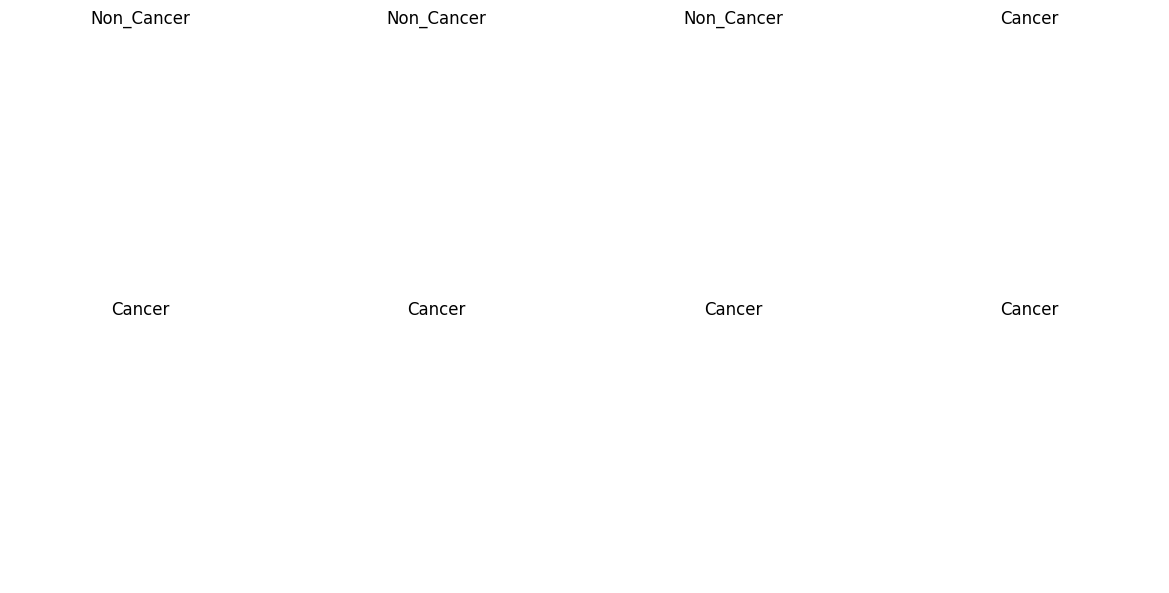

In [5]:
# --- CELDA 4 ---
def show_batch(ds, n=16):
    imgs, labs = next(iter(ds))
    n = min(n, imgs.shape[0])
    cols = 4; rows = math.ceil(n/cols)
    plt.figure(figsize=(12, 3*rows))
    for i in range(n):
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(imgs[i].numpy())
        lbl = int(labs[i].numpy())
        plt.title("Cancer" if lbl==1 else "Non_Cancer")
        plt.axis("off")
    plt.tight_layout(); plt.show()

show_batch(train_ds)


In [6]:
# --- CELDA 5 ---
from keras.applications import efficientnet_v2

def build_baseline(input_shape=(224,224,3), dropout=0.25, l2_reg=1e-6, train_backbone=False):
    base = efficientnet_v2.EfficientNetV2B0(
        include_top=False, weights="imagenet", input_shape=input_shape
    )
    base.trainable = train_backbone  # baseline: congelado

    inp = keras.Input(shape=input_shape)
    x = efficientnet_v2.preprocess_input(inp)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation="sigmoid",
                       kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    return keras.Model(inp, out, name="effnetv2_b0_bin")

model = build_baseline(input_shape=(*IMG_SIZE,3))
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc"), keras.metrics.Precision(name="precision"), keras.metrics.Recall(name="recall")]
)
model.summary()


Model: "effnetv2_b0_bin"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,920,593 (22.59 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 580ms/step - accuracy: 0.4627 - auc: 0.4153 - loss: 0.7705 - precision: 0.4375 - recall: 0.2059 - val_accuracy: 0.2941 - val_auc: 0.2083 - val_loss: 0.7996 - val_precision: 0.3000 - val_recall: 0.3750 - learning_rate: 0.0010
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.5224 - auc: 0.5989 - loss: 0.6769 - precision: 0.5217 - recall: 0.7059 - val_accuracy: 0.4118 - val_auc: 0.4028 - val_loss: 0.7692 - val_precision: 0.4375 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.6716 - auc: 0.7184 - loss: 0.6260 - precision: 0.6250 - recall: 0.8824 - val_accuracy: 0.5882 - val_auc: 0.5556 - val_loss: 0.7393 - val_precision: 0.5333 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.7015 - auc: 0.8093 - loss: 0.5830 - precision: 0.6591 - recall: 0.8529 - val_accuracy: 0.5882 - val_auc: 0.6250 - val_loss: 0.7023 - val_precision:

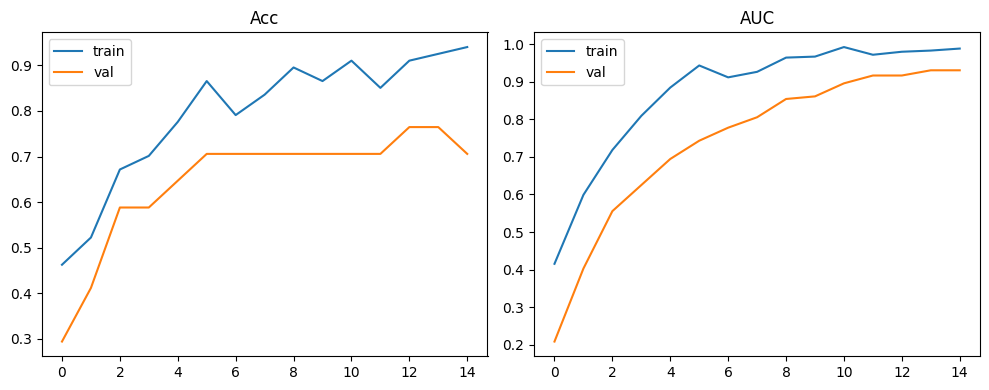

In [ ]:
# --- CELDA 6 ---
os.makedirs("runs", exist_ok=True)

cbs = [
    callbacks.ModelCheckpoint("runs/best_baseline.keras", monitor="val_auc", mode="max", save_best_only=True),
    callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3),
    callbacks.CSVLogger("runs/train_log_baseline.csv", append=False),
]

H1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=cbs
)

# Pequeño plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(H1.history["accuracy"]); plt.plot(H1.history["val_accuracy"]); plt.title("Acc"); plt.legend(["train","val"])
plt.subplot(1,2,2); plt.plot(H1.history["auc"]); plt.plot(H1.history["val_auc"]); plt.title("AUC"); plt.legend(["train","val"])
plt.tight_layout(); plt.show()


In [ ]:
# --- CELDA 7 ---
model_ft = keras.models.load_model("runs/best_baseline.keras")

# localizar backbone 
backbone = None
for lyr in model_ft.layers:
    if isinstance(lyr, keras.Model) and len(lyr.layers) > 10:
        backbone = lyr; break
assert backbone is not None

# descongelar último ~30% de capas
n = len(backbone.layers)
cut = int(n * 0.7)
for i, layer in enumerate(backbone.layers):
    layer.trainable = (i >= cut)

model_ft.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc"), keras.metrics.Precision(name="precision"), keras.metrics.Recall(name="recall")]
)

cbs_ft = [
    callbacks.ModelCheckpoint("runs/best_finetune.keras", monitor="val_auc", mode="max", save_best_only=True),
    callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3),
    callbacks.CSVLogger("runs/train_log_finetune.csv", append=False),
]

H2 = model_ft.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cbs_ft
)


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 789ms/step - accuracy: 0.8060 - auc: 0.9189 - loss: 0.4592 - precision: 0.7692 - recall: 0.8824 - val_accuracy: 0.8824 - val_auc: 0.9444 - val_loss: 0.4638 - val_precision: 0.8000 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.8209 - auc: 0.9015 - loss: 0.4770 - precision: 0.8056 - recall: 0.8529 - val_accuracy: 0.8824 - val_auc: 0.9444 - val_loss: 0.4714 - val_precision: 0.8000 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.7612 - auc: 0.8868 - loss: 0.4887 - precision: 0.7368 - recall: 0.8235 - val_accuracy: 0.8824 - val_auc: 0.9444 - val_loss: 0.4796 - val_precision: 0.8000 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.7612 - auc: 0.8801 - loss: 0.4950 - precision: 0.7143 - recall: 0.8824 - val_accuracy: 0.8235 - val_auc: 0.9167 - val_loss: 0.4992 

Test AUC: 0.8375955320399765
Classification report:
               precision    recall  f1-score   support

  Non_Cancer     0.9231    0.7407    0.8219       162
      Cancer     0.4324    0.7619    0.5517        42

    accuracy                         0.7451       204
   macro avg     0.6778    0.7513    0.6868       204
weighted avg     0.8221    0.7451    0.7663       204



2025-11-11 21:35:41.539552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


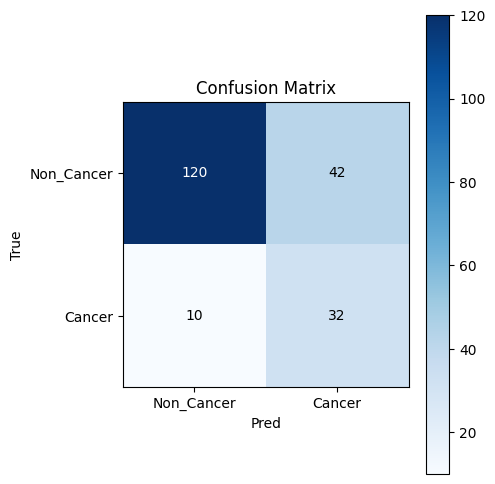

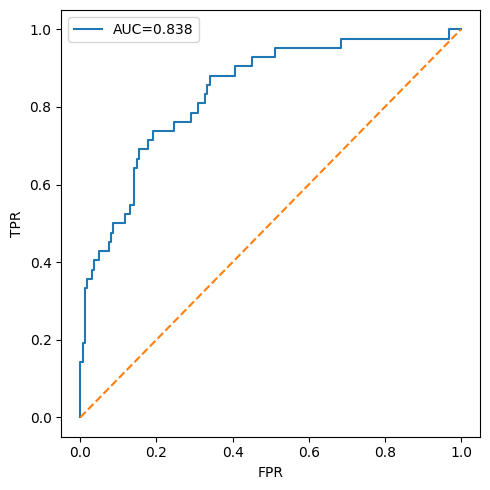

In [9]:
# --- CELDA 8 ---
final_path = "runs/best_finetune.keras" if os.path.exists("runs/best_finetune.keras") else "runs/best_baseline.keras"
final_model = keras.models.load_model(final_path)

# Recolectar todo test para métricas clásicas
y_true_list, y_prob_list = [], []
for batch_x, batch_y in test_ds:
    p = final_model.predict(batch_x, verbose=0).ravel()
    y_prob_list.extend(p.tolist())
    y_true_list.extend(batch_y.numpy().tolist())

y_true = np.array(y_true_list).astype(int)
y_prob = np.array(y_prob_list)
y_pred = (y_prob >= 0.5).astype(int)

print("Test AUC:", roc_auc_score(y_true, y_prob))
print("Classification report:\n", classification_report(y_true, y_pred, target_names=["Non_Cancer","Cancer"], digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,5))
plt.imshow(cm, cmap="Blues"); plt.title("Confusion Matrix"); plt.colorbar()
ticks = np.arange(2)
plt.xticks(ticks, ["Non_Cancer","Cancer"]); plt.yticks(ticks, ["Non_Cancer","Cancer"])
th = cm.max()/2
for i,j in itertools.product(range(2), range(2)):
    plt.text(j, i, cm[i,j], ha="center", va="center", color=("white" if cm[i,j]>th else "black"))
plt.xlabel("Pred"); plt.ylabel("True"); plt.tight_layout()
os.makedirs("reports/figures", exist_ok=True)
plt.savefig("reports/figures/confusion_matrix.png", dpi=160); plt.show()

# ROC
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_true, y_prob):.3f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.tight_layout()
plt.savefig("reports/figures/roc_curve.png", dpi=160); plt.show()


In [ ]:
# --- CELDA 9 ---
from PIL import Image
import numpy as np
import os
from tensorflow import keras

# Selecciona el mejor modelo entrenado
FINAL_MODEL = (
    "runs/best_finetune.keras"
    if os.path.exists("runs/best_finetune.keras")
    else "runs/best_baseline.keras"
)

def predict_image(path, threshold=0.5, model_path=FINAL_MODEL):
    mdl = keras.models.load_model(model_path)
    img = Image.open(path).convert("RGB").resize(IMG_SIZE)

    x = np.array(img, dtype="float32")[None, ...]  # [1,H,W,3]

    prob = float(mdl.predict(x, verbose=0)[0][0])
    label = "Cancer" if prob >= threshold else "Non_Cancer"
    return {
        "file": os.path.basename(path),
        "label": label,
        "prob_cancer": round(prob, 4)
    }

# ---- Ejemplos con tus imágenes ----
pred_cancer = predict_image("../Con_Cancer_Internet.jpg", threshold=0.5)
pred_normal = predict_image("../Sin_Cancer_Internet.jpg", threshold=0.5)

print("Resultado imagen con cáncer:", pred_cancer)
print("Resultado imagen sin cáncer:", pred_normal)


Resultado imagen con cáncer: {'file': 'Con_Cancer.jpg', 'label': 'Cancer', 'prob_cancer': 0.7443}
Resultado imagen sin cáncer: {'file': 'Sin_Cancer.jpg', 'label': 'Cancer', 'prob_cancer': 0.6088}
